In [2]:
!ls ../data/ -l

总用量 4682864
-rw-rw-r--   1 lyz lyz         48 6月  23 09:38 submit_sample.csv
drwxrwxr-x   3 lyz lyz     180224 6月  23 09:47 初赛_测试集
-rw-rw-r--   1 lyz lyz 4795054696 6月  22 19:24 科大讯飞股份有限公司_广告图片素材分类算法挑战赛.zip
drwxrwxr-x 139 lyz lyz       4096 6月  18 00:39 训练集


In [3]:
!ls ../data/训练集/

0    105  112  12   127  134  19  26  33  40  48  55  62  7   77  84  91  99
1    106  113  120  128  135  2   27  34  41  49  56  63  70  78  85  92
10   107  114  121  129  136  20  28  35  42  5   57  64  71  79  86  93
100  108  115  122  13	 14   21  29  36  43  50  58  65  72  8   87  94
101  109  116  123  130  15   22  3   37  44  51  59  66  73  80  88  95
102  11   117  124  131  16   23  30  38  45  52  6   67  74  81  89  96
103  110  118  125  132  17   24  31  39  46  53  60  68  75  82  9   97
104  111  119  126  133  18   25  32  4   47  54  61  69  76  83  90  98


In [12]:
import pandas as pd
import cv2
import glob

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [34]:
train_df = pd.DataFrame({'path': glob.glob('../data/训练集/*/*')})
train_df['label'] = train_df['path'].apply(lambda x: int(x.split('/')[-2]))

In [50]:
train_df['label'].nunique()

137

# 数据分析

In [35]:
def show_image(paths):
    plt.figure(figsize=(10, 8))
    for idx, path in enumerate(paths):
        plt.subplot(1, len(paths), idx+1)
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.xticks([]); plt.yticks([])

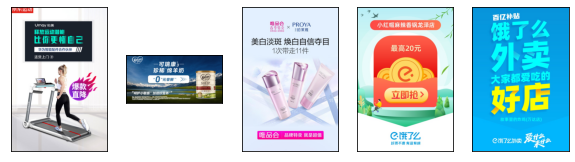

In [36]:
show_image(train_df.sample(5)['path'])

<AxesSubplot:>

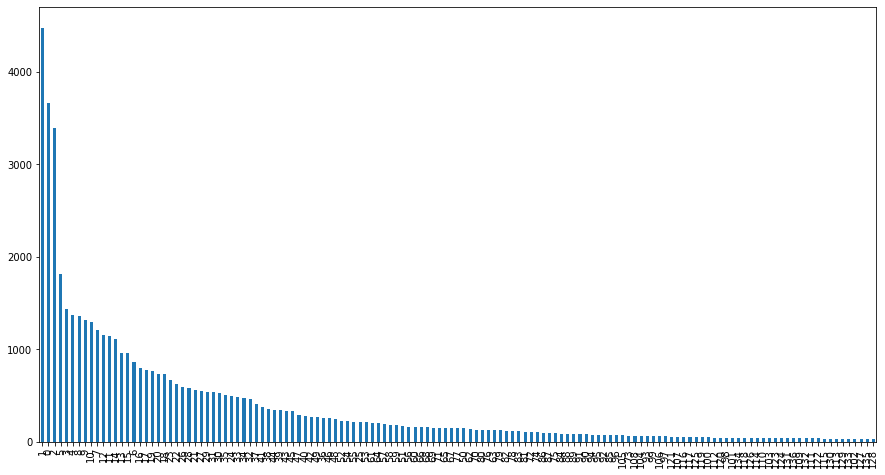

In [37]:
plt.figure(figsize=(15, 8))
train_df['label'].value_counts().plot(kind='bar')

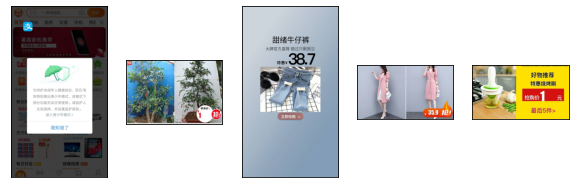

In [38]:
show_image(train_df[train_df['label'] == 1].sample(5)['path'])

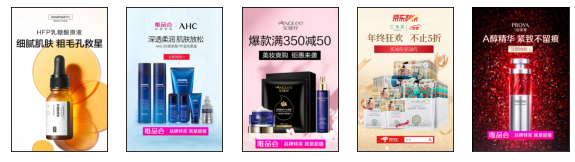

In [40]:
show_image(train_df[train_df['label'] == 0].sample(5)['path'])

# 模型训练

In [41]:
import os, sys, codecs, glob
from PIL import Image, ImageDraw

import numpy as np
import pandas as pd
import cv2

import torch
torch.backends.cudnn.benchmark = False
# torch.backends.cudnn.enabled = False

import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data.dataset import Dataset

In [107]:
class XunFeiDataset(Dataset):
    def __init__(self, img_path, img_label, transform=None):
        self.img_path = img_path
        self.img_label = img_label
        self.transform = transform

    def __getitem__(self, index):
        # print(self.img_path[index], cv2.imread(self.img_path[index]).shape)
        img = Image.open(self.img_path[index]).convert('RGB')
        
        if self.transform is not None:
            img = self.transform(img)
        
        label = torch.from_numpy(np.array([self.img_label[index]]))
        return img, label

    def __len__(self):
        return len(self.img_path)

In [91]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        # print(correct.shape)
        res = []
        for k in topk:
            # print(correct[:k].shape)
            correct_k = correct[:k].float().sum()
            res.append(correct_k.mul_(100.0 / batch_size))
            
        # print(res)
        return res

In [118]:
train_df = train_df.sample(frac = 1.0)

train_loader = torch.utils.data.DataLoader(
    XunFeiDataset(train_df['path'].values[:-2000], train_df['label'].values[:-2000],
                        transforms.Compose([
                        transforms.Resize((300, 300)),
                        transforms.RandomHorizontalFlip(),
                        transforms.RandomVerticalFlip(),
                        transforms.RandomAffine(5, scale=[0.95, 1.05]),
                        transforms.RandomCrop((256, 256)),
                        transforms.ToTensor(),
                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    ),
    batch_size=50, shuffle=True, num_workers=5,
)

val_loader = torch.utils.data.DataLoader(
    XunFeiDataset(train_df['path'].values[-2000:], train_df['label'].values[-2000:],
                        transforms.Compose([
                        transforms.Resize((256, 256)),
                        transforms.RandomHorizontalFlip(),
                        transforms.RandomVerticalFlip(),
                        transforms.ToTensor(),
                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    ),
    batch_size=50, shuffle=False, num_workers=5,
)

In [119]:
import timm
model = timm.create_model('efficientnet_b0', num_classes=137, 
                          pretrained=True, in_chans=3)

In [120]:
model = model.cuda()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=len(train_loader) / 10, gamma=0.95)

print('Epoch/Batch\t\tTrain: loss/Top1/Top3\t\tTest: loss/Top1/Top3')

for epoch in range(1):
    train_losss, train_acc1s, train_acc5s = [], [], []
    for i, data in enumerate(train_loader):
        scheduler.step()
        model = model.train()
        train_img, train_label = data
        optimizer.zero_grad()
        
        train_img = Variable(train_img).cuda()
        train_label = Variable(train_label.view(-1)).cuda()

        output = model(train_img)
        train_loss = loss_fn(output, train_label)
        
        train_loss.backward()
        optimizer.step()
        
        train_losss.append(train_loss.item())

        if i % int(100) == 0:
            val_losss, val_acc1s, val_acc5s = [], [], []
            
            with torch.no_grad():
                train_acc1, train_acc3 = accuracy(output, train_label, topk=(1, 3))
                train_acc1s.append(train_acc1.data.item())
                train_acc5s.append(train_acc3.item())
            
                for data in val_loader:
                    val_images, val_labels = data
                    
                    # val_images = Variable(val_images).cuda(async=True)
                    # val_labels = Variable(val_labels.view(-1)).cuda()

                    val_images = Variable(val_images).cuda()
                    val_labels = Variable(val_labels.view(-1)).cuda() 
                    
                    output = model(val_images)
                    val_loss = loss_fn(output, val_labels)
                    val_acc1, val_acc3 = accuracy(output, val_labels, topk=(1, 3))
                    
                    val_losss.append(val_loss.item())
                    val_acc1s.append(val_acc1.item())
                    val_acc5s.append(val_acc3.item())
                    
            logstr = '{0:2s}/{1:6s}\t\t{2:.4f}/{3:.4f}/{4:.4f}\t\t{5:.4f}/{6:.4f}/{7:.4f}'.format(
                    str(epoch), str(i),
                    np.mean(train_losss, 0), np.mean(train_acc1s, 0), np.mean(train_acc5s, 0),
                    np.mean(val_losss, 0), np.mean(val_acc1s, 0), np.mean(val_acc5s, 0),
                )
            torch.save(model.state_dict(), '.model_{0}.pt'.format(epoch))
            print(logstr)

Epoch/Batch		Train: loss/Top1/Top3		Test: loss/Top1/Top3
0 /0     		5.0060/2.0000/2.0000		4.7274/9.9500/16.7000
0 /100   		4.1356/10.0000/18.0000		3.6042/22.0000/34.9500
0 /200   		3.8388/18.0000/28.6667		3.3835/24.7500/39.1000
0 /300   		3.6702/20.0000/33.5000		3.3034/24.4500/40.0500
0 /400   		3.5435/22.0000/35.6000		3.1019/29.5500/45.2500
0 /500   		3.4333/23.3333/37.0000		2.9650/31.4000/48.4500
0 /600   		3.3566/23.1429/38.5714		2.9195/31.5500/48.3500
0 /700   		3.2890/24.0000/40.5000		2.8279/33.4500/51.6500
0 /800   		3.2269/24.6667/41.3333		2.7223/35.4500/51.7500
0 /900   		3.1695/25.6000/42.0000		2.6637/36.5000/53.6000


In [122]:
test_df = pd.DataFrame({'path': glob.glob('../data/初赛_测试集/*')})
test_df['label'] = 0

In [125]:
test_loader = torch.utils.data.DataLoader(
    XunFeiDataset(test_df['path'].values[:], test_df['label'].values[:],
                        transforms.Compose([
                        transforms.Resize((256, 256)),
                        transforms.RandomHorizontalFlip(),
                        transforms.RandomVerticalFlip(),
                        transforms.ToTensor(),
                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    ),
    batch_size=50, shuffle=False, num_workers=5,
)

In [127]:
pred_tta = []
for tti in range(5):
    pred = []
    with torch.no_grad():
        for t, (x, y) in enumerate(test_loader):
            x_var = Variable(x).cuda(async=True)
            y_var = Variable(y).cuda()
            scores = model(x_var)
            pred.append(scores.data.cpu().numpy())
    pred = np.concatenate(pred, 0)    
    print(tti)
    pred_tta.append(pred)

pred = np.mean(pred_tta, axis=0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: This overload of cuda is deprecated:
	cuda(torch.device device, bool async, *, torch.memory_format memory_format)
Consider using one of the following signatures instead:
	cuda(torch.device device, bool non_blocking, *, torch.memory_format memory_format) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  


0
1
2
3
4


In [132]:
test_df['category_id'] = pred.argmax(1)
test_df['image_id'] = test_df['path'].apply(lambda x: x.split('/')[-1])

In [134]:
test_df[['image_id','category_id']].to_csv('submit.csv', index=None)